## **Import required libraries**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import joblib


## **Define Churn and Label Customers**

In [2]:
df = pd.read_csv('rfm_labeled.csv')


In [3]:
def suggest_churn_threshold(recency_series):
    max_rec = recency_series.max()
    median_rec = recency_series.median()
    p75 = recency_series.quantile(0.75)
    p80 = recency_series.quantile(0.80)
    p90 = recency_series.quantile(0.90)

    return int(p80)

CHURN_THRESHOLD = suggest_churn_threshold(df['Recency'])


In [4]:
df['Churn'] = df['Recency'].apply(lambda x: 0 if x > CHURN_THRESHOLD else 1)


In [5]:
print("Churn Label Breakdown:")
print(df['Churn'].value_counts())


Churn Label Breakdown:
Churn
1    4701
0    1159
Name: count, dtype: int64


In [6]:
print("\nSample labeled data:")
print(df[['CustomerID', 'Recency', 'Churn']].head())



Sample labeled data:
   CustomerID  Recency  Churn
0       12346      320      1
1       12347       34      1
2       12348       70      1
3       12349       13      1
4       12350      305      1


In [7]:
df.to_csv('churn_labeled_data.csv', index=False)
print("\n churn_labeled_data.csv exported with Churn column added.")



 churn_labeled_data.csv exported with Churn column added.


## **Prepare Features and Target (X, y)**

In [8]:
df_features = df.drop(columns=['CustomerID', 'Segment'])


In [9]:
X = df_features.drop(columns='Churn')
y = df_features['Churn']


In [10]:
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
print("\nFeatures preview:")
print(X.head())


Feature matrix shape: (5860, 4)
Target vector shape: (5860,)

Features preview:
   Recency  Frequency  Monetary  Cluster
0      320         12  77556.46        4
1       34          7   5408.50        1
2       70          5   2019.40        1
3       13          4   4428.69        1
4      305          1    334.40        0


# **Train/Test Split**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## **Train Machine Learning Models**

### **Logistic Regression with Cross-Validation**

In [12]:
log_reg = LogisticRegression(solver='liblinear', random_state=42)

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}


In [13]:
grid_lr = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             scoring='f1')

Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l1'}

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       232
           1       1.00      1.00      1.00       940

    accuracy                           1.00      1172
   macro avg       1.00      1.00      1.00      1172
weighted avg       1.00      1.00      1.00      1172



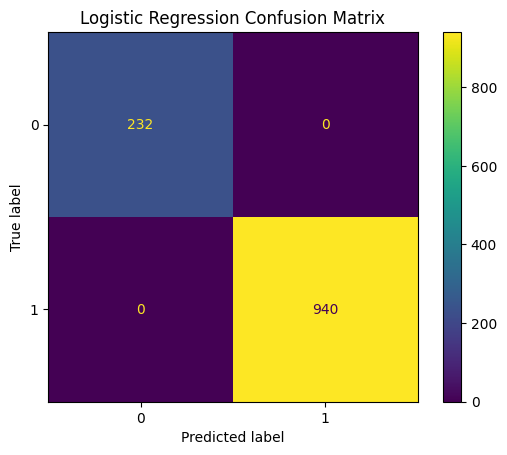

In [14]:
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)

print("Best Logistic Regression Parameters:", grid_lr.best_params_)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test)
plt.title("Logistic Regression Confusion Matrix")
plt.grid(False)
plt.show()


### **Random Forest with Tuning**

In [15]:
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [16]:
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1')

Best Random Forest Parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       232
           1       1.00      1.00      1.00       940

    accuracy                           1.00      1172
   macro avg       1.00      1.00      1.00      1172
weighted avg       1.00      1.00      1.00      1172



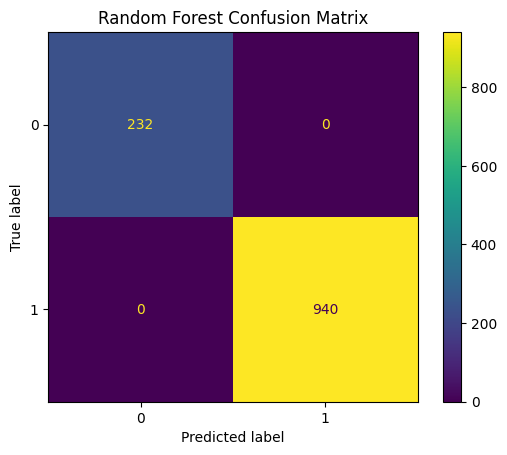

In [17]:
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Best Random Forest Parameters:", grid_rf.best_params_)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Random Forest Confusion Matrix")
plt.grid(False)
plt.show()


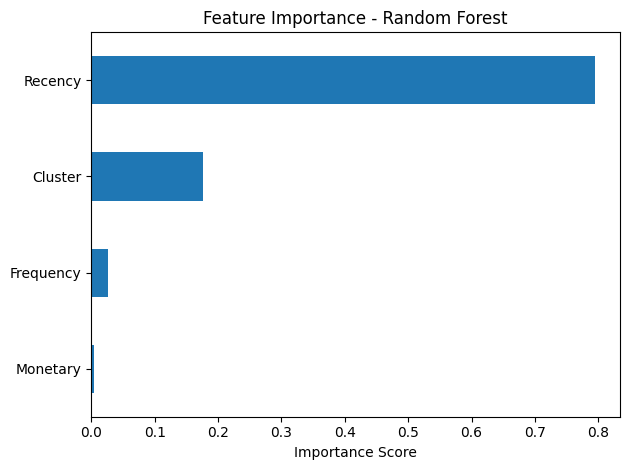

In [18]:
feature_importance = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importance.sort_values().plot(kind='barh', title="Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


### **XGBoost Classifier**

In [19]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}


In [20]:
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='f1')

Best XGBoost Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       232
           1       1.00      1.00      1.00       940

    accuracy                           1.00      1172
   macro avg       1.00      1.00      1.00      1172
weighted avg       1.00      1.00      1.00      1172



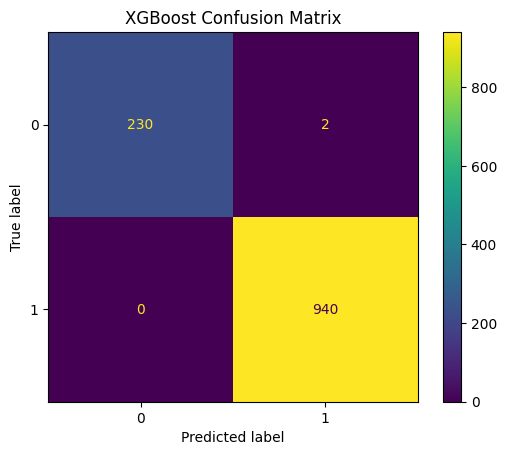

In [21]:
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("Best XGBoost Parameters:", grid_xgb.best_params_)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test)
plt.title("XGBoost Confusion Matrix")
plt.grid(False)
plt.show()


### **Model Comparison**

In [22]:
from sklearn.metrics import f1_score

f1_lr = f1_score(y_test, y_pred_lr)
f1_rf = f1_score(y_test, y_pred_rf)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("F1 Scores on Test Set:")
print(f"Logistic Regression: {f1_lr:.4f}")
print(f"Random Forest:       {f1_rf:.4f}")
print(f"XGBoost:             {f1_xgb:.4f}")


F1 Scores on Test Set:
Logistic Regression: 1.0000
Random Forest:       1.0000
XGBoost:             0.9989


In [23]:
best_model = None
best_name = None
best_score = max(f1_lr, f1_rf, f1_xgb)

if best_score == f1_rf:
    best_model = best_rf
    best_name = 'Random Forest'
elif best_score == f1_lr:
    best_model = best_lr
    best_name = 'Logistic Regression'
else:
    best_model = best_xgb
    best_name = 'XGBoost'

print(f"\nBest model based on F1-score: {best_name} with F1 = {best_score:.4f}")



Best model based on F1-score: Random Forest with F1 = 1.0000


## **Visualize the Model Internally**

### **Feature Importance**

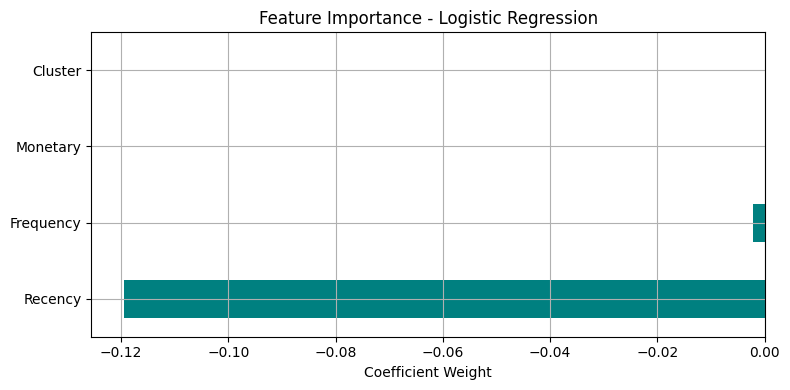

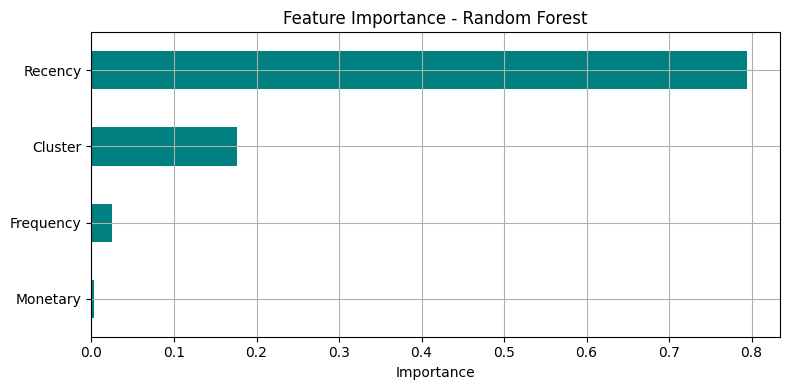

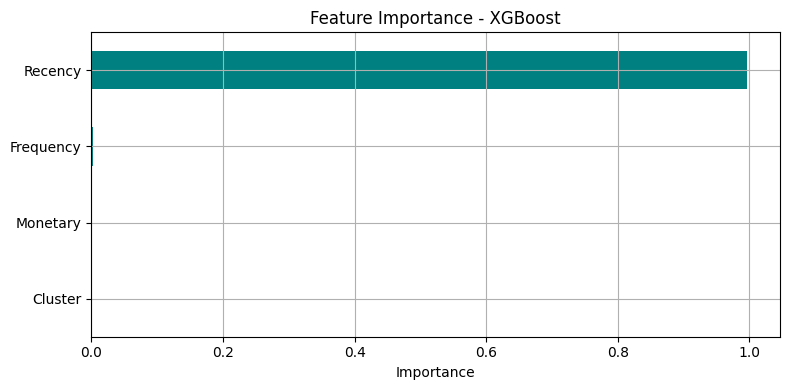

In [24]:
def plot_feature_importance(model, model_name, feature_names):
    if model_name == 'Logistic Regression':
        importances = pd.Series(model.coef_[0], index=feature_names)
    else:
        importances = pd.Series(model.feature_importances_, index=feature_names)

    importances = importances.sort_values(ascending=True)

    plt.figure(figsize=(8, 4))
    importances.plot(kind='barh', color='teal')
    plt.title(f"Feature Importance - {model_name}")
    plt.xlabel("Importance" if model_name != 'Logistic Regression' else "Coefficient Weight")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_lr, "Logistic Regression", X.columns)
plot_feature_importance(best_rf, "Random Forest", X.columns)
plot_feature_importance(best_xgb, "XGBoost", X.columns)


### **Churn Probability Distribution**

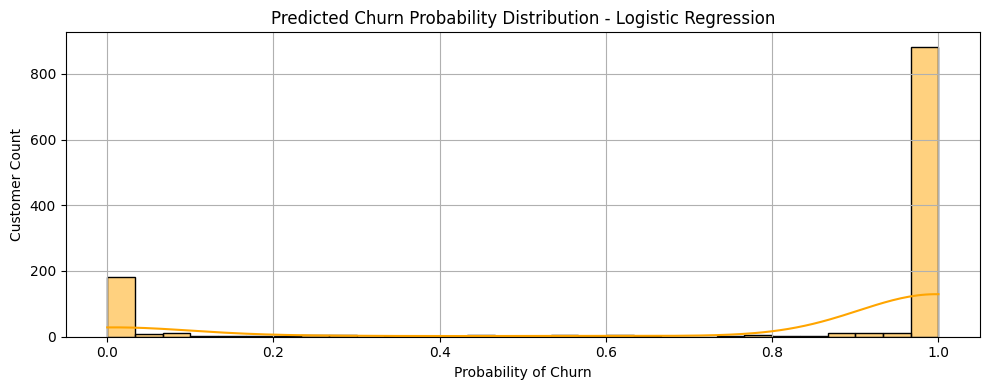

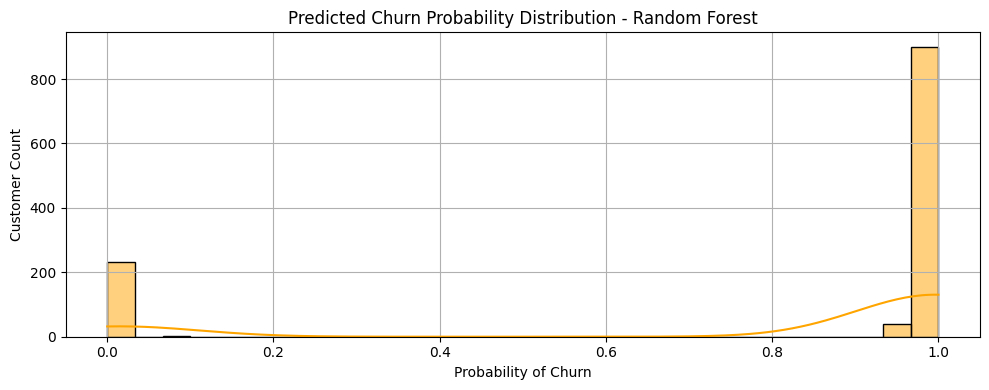

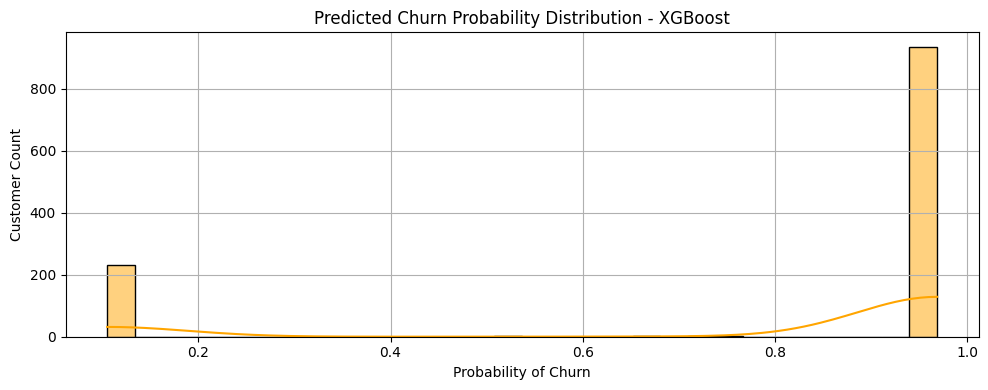

In [25]:
def plot_churn_probability(model, model_name):
    churn_probs = model.predict_proba(X_test)[:, 1]

    plt.figure(figsize=(10, 4))
    sns.histplot(churn_probs, bins=30, kde=True, color='orange')
    plt.title(f"Predicted Churn Probability Distribution - {model_name}")
    plt.xlabel("Probability of Churn")
    plt.ylabel("Customer Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_churn_probability(best_lr, "Logistic Regression")
plot_churn_probability(best_rf, "Random Forest")
plot_churn_probability(best_xgb, "XGBoost")


### **Check Prediction Confidence vs Accuracy**

/tmp/ipython-input-26-4068957121.py:16: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


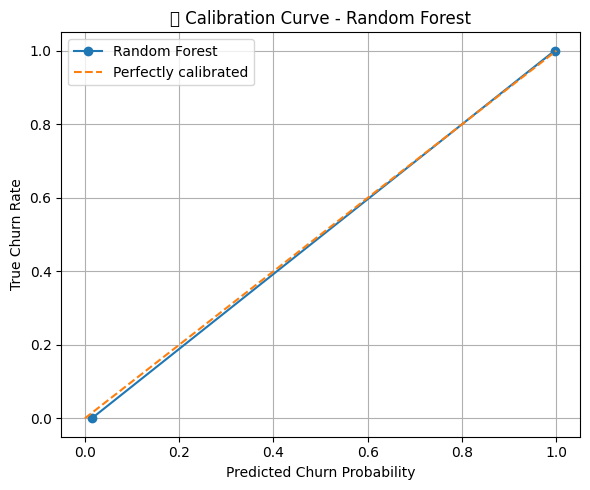

/tmp/ipython-input-26-4068957121.py:16: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


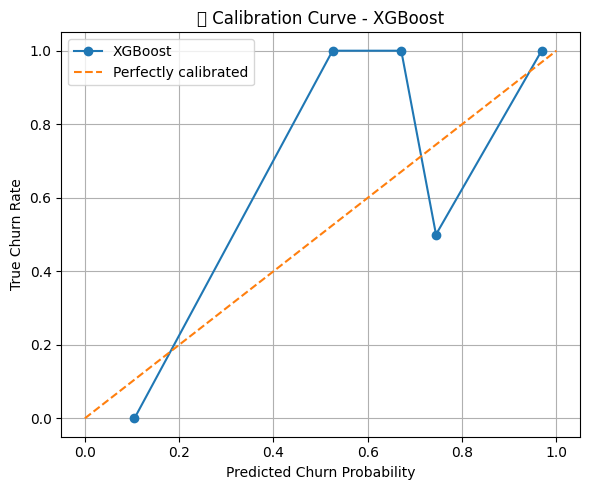

/tmp/ipython-input-26-4068957121.py:16: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


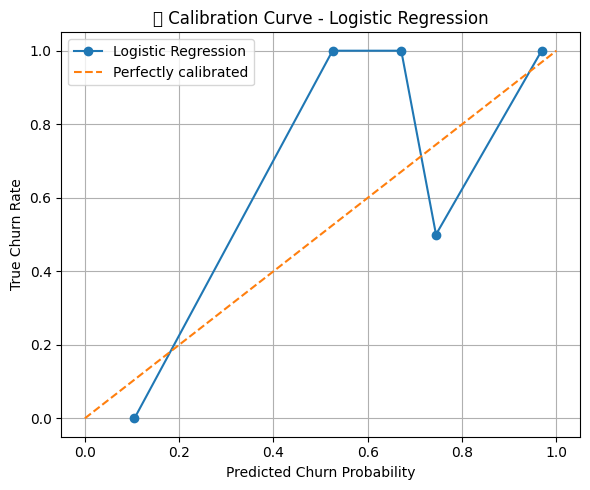

In [26]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(model, X, y, name):
    y_prob = model.predict_proba(X)[:, 1]
    prob_true, prob_pred = calibration_curve(y, y_prob, n_bins=10)

    plt.figure(figsize=(6, 5))
    plt.plot(prob_pred, prob_true, marker='o', label=f'{name}')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.title(f'📈 Calibration Curve - {name}')
    plt.xlabel('Predicted Churn Probability')
    plt.ylabel('True Churn Rate')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_calibration_curve(best_rf, X_test, y_test, "Random Forest")
plot_calibration_curve(best_xgb, X_test, y_test, "XGBoost")
plot_calibration_curve(best_xgb, X_test, y_test, "Logistic Regression")


## **Predict Churn for All Customers and Export**

In [27]:
X_full = df.drop(columns=['CustomerID', 'Segment', 'Churn'])
customer_ids = df['CustomerID']


In [28]:
final_model = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'XGBoost': best_xgb
}[best_name]


In [29]:
df['Predicted_Churn'] = final_model.predict(X_full)
df['Churn_Probability'] = final_model.predict_proba(X_full)[:, 1]

print(df[['CustomerID', 'Churn', 'Predicted_Churn', 'Churn_Probability']].head())

df.to_csv('churn_predictions.csv', index=False)
print("Exported churn_predictions.csv using the best model dynamically.")


   CustomerID  Churn  Predicted_Churn  Churn_Probability
0       12346      1                1            1.00000
1       12347      1                1            1.00000
2       12348      1                1            1.00000
3       12349      1                1            1.00000
4       12350      1                1            0.96249
Exported churn_predictions.csv using the best model dynamically.


## **Save Model**

In [30]:
joblib.dump(best_lr, 'logistic_model.pkl')
joblib.dump(best_rf, 'rf_model.pkl')
joblib.dump(best_xgb, 'xgboost_model.pkl')


['xgboost_model.pkl']

In [31]:
model_tag = best_name.lower().replace(" ", "_")
best_filename = f"{model_tag}_best.pkl"

joblib.dump(final_model, best_filename)

print("All models saved.")
print(f"Best model: {best_name}")
print(f"Best model also saved as: {best_filename}")


All models saved.
Best model: Random Forest
Best model also saved as: random_forest_best.pkl
